## 数据集：
Melbourne Airbnb Open Data / listings_summary_dec18.csv（包含16列22895行的2018年12月墨尔本Airbnb短租总体信息与指标的数据列表）

属性： id: 用于标识房间的号码，一个房间有独一份的id；name: 房东给房间起的名字；host_id: 房东的唯一识别码；host_name: 房东的名字；neighbourhood_group: 地区分组；neighbourhood: 地区；latitude: 纬度；longitude: 经度；room_type: 房型；price: 价格；minimum_nights: 最少住几晚；number_of_reviews: 评论数；last_review: 最新的评论；reviews_per_month: 每月平均评论数；calculated_host_listings_count: 有多少间房；availability_365: 一年有多少天是可用的

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
file = "melbourne-airbnb-open-data/listings_summary_dec18.csv"
df = pd.read_csv(file)

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,9835,Beautiful Room & House,33057,Manju,NaN,Manningham,-37.772684,145.092133,Private room,60,1,4,2015-09-12,0.04,1,365
1,10803,Room in Cool Deco Apartment in Brunswick,38901,Lindsay,NaN,Moreland,-37.766505,144.980736,Private room,35,3,108,2018-11-26,1.50,1,213
2,12936,St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC,50121,Frank & Vince,NaN,Port Phillip,-37.859755,144.977369,Entire home/apt,159,3,15,2018-11-07,0.15,17,326
3,15246,Large private room-close to city,59786,Eleni,NaN,Darebin,-37.758971,144.989228,Private room,50,2,29,2017-05-15,0.30,3,0
4,16760,Melbourne BnB near City & Sports,65090,Colin,NaN,Port Phillip,-37.864530,144.992238,Private room,69,1,63,2018-11-22,0.74,1,328


## 1. 对数据集进行处理：
我们选出地区（neighbourhood）与房型（room_type）这两个属性，来分析地区、房型二者之间的关系。

In [4]:
transactions = []
for index, row in df.iterrows():
    transactions += [(row['neighbourhood'], row['room_type'])]
transactions[:10]

[('Manningham', 'Private room'),
 ('Moreland', 'Private room'),
 ('Port Phillip', 'Entire home/apt'),
 ('Darebin', 'Private room'),
 ('Port Phillip', 'Private room'),
 ('Casey', 'Entire home/apt'),
 ('Darebin', 'Private room'),
 ('Melbourne', 'Private room'),
 ('Monash', 'Entire home/apt'),
 ('Frankston', 'Private room')]

## 2. 找出频繁模式：
Apriori算法：

In [5]:
from collections import defaultdict
import itertools

def apriori(transactions, support=0.1, confidence=0.8, lift=1, minlen=2, maxlen=2):
    item_2_tranidxs = defaultdict(list)
    itemset_2_tranidxs = defaultdict(list)
    for tranidx, tran in enumerate(transactions):
        for item in tran:
            item_2_tranidxs[item].append(tranidx)
            itemset_2_tranidxs[frozenset([item])].append(tranidx)
    item_2_tranidxs = dict([(k, frozenset(v)) for k, v in item_2_tranidxs.items()])
    itemset_2_tranidxs = dict([
        (k, frozenset(v)) for k, v in itemset_2_tranidxs.items()])
    tran_count = float(len(transactions))
    valid_items = set(item
        for item, tranidxs in item_2_tranidxs.items()
            if (len(tranidxs) / tran_count >= support))
    pivot_itemsets = [frozenset([item]) for item in valid_items]
    freqsets = []
    if minlen == 1:
        freqsets.extend(pivot_itemsets)
    for i in range(maxlen - 1):
        new_itemset_size = i + 2
        new_itemsets = []
        for pivot_itemset in pivot_itemsets:
            pivot_tranidxs = itemset_2_tranidxs[pivot_itemset]
            for item, tranidxs in item_2_tranidxs.items():
                if item not in pivot_itemset:
                    common_tranidxs = pivot_tranidxs & tranidxs
                    if len(common_tranidxs) / tran_count >= support:
                        new_itemset = frozenset(pivot_itemset | set([item]))
                        if new_itemset not in itemset_2_tranidxs:
                            new_itemsets.append(new_itemset)
                            itemset_2_tranidxs[new_itemset] = common_tranidxs
        if new_itemset_size > minlen - 1:
            freqsets.extend(new_itemsets)
        pivot_itemsets = new_itemsets
    for freqset in freqsets:
        for item in freqset:
            rhs = frozenset([item])
            lhs = freqset - rhs
            support_rhs = len(itemset_2_tranidxs[rhs]) / tran_count
            if len(lhs) == 0:
                lift_rhs = float(1)
                if support_rhs >= support and support_rhs > confidence and lift_rhs > lift:
                    yield (lhs, rhs, support_rhs, support_rhs, lift_rhs)
            else:
                confidence_lhs_rhs = len(itemset_2_tranidxs[freqset]) \
                    / float(len(itemset_2_tranidxs[lhs]))
                lift_lhs_rhs = confidence_lhs_rhs / support_rhs

                if confidence_lhs_rhs >= confidence and lift_lhs_rhs > lift:
                    support_lhs_rhs = len(itemset_2_tranidxs[freqset]) / tran_count
                    yield (lhs, rhs, support_lhs_rhs, confidence_lhs_rhs, lift_lhs_rhs)

频繁项集设置为support>0.03, confidence>0.1, lift>1：

In [6]:
rules = apriori(transactions, support=0.03, confidence=0.1, lift=1)
rules_sorted = sorted(rules, key=lambda x: (x[4], x[3], x[2]), reverse=True)
for r in rules_sorted:
    print(r)

(frozenset({'Port Phillip'}), frozenset({'Entire home/apt'}), 0.09167940598383927, 0.7475071225071225, 1.1902201522915759)
(frozenset({'Entire home/apt'}), frozenset({'Port Phillip'}), 0.09167940598383927, 0.14597677168092357, 1.1902201522915759)
(frozenset({'Melbourne'}), frozenset({'Entire home/apt'}), 0.23345708670015286, 0.7254343105320304, 1.1550746602427733)
(frozenset({'Entire home/apt'}), frozenset({'Melbourne'}), 0.23345708670015286, 0.3717226510883928, 1.1550746602427733)
(frozenset({'Stonnington'}), frozenset({'Entire home/apt'}), 0.050709761956759115, 0.716224552745219, 1.1404103995480763)
(frozenset({'Yarra'}), frozenset({'Entire home/apt'}), 0.05892116182572614, 0.6583699365544168, 1.048291237041058)


## 3. 导出关联规则，计算其支持度和置信度：

In [7]:
import csv 

with open('result.csv', 'wt') as f:
    f_csv = csv.writer(f, delimiter=',')
    f_csv.writerow(['rule', 'sup', 'conf', 'lift'])
    for r in rules_sorted:
        f_csv.writerow([f'{str(list(r[0])[0])} => {str(list(r[1])[0])}', r[2], r[3], r[4]])

pd.read_csv('result.csv')

,rule,sup,conf,lift
0,Port Phillip => Entire home/apt,0.091679,0.747507,1.190220
1,Entire home/apt => Port Phillip,0.091679,0.145977,1.190220
2,Melbourne => Entire home/apt,0.233457,0.725434,1.155075
3,Entire home/apt => Melbourne,0.233457,0.371723,1.155075
4,Stonnington => Entire home/apt,0.050710,0.716225,1.140410
5,Yarra => Entire home/apt,0.058921,0.658370,1.048291


## 4. 对规则进行评价：
计算Kulc:

In [8]:
res = []
for r in rules_sorted:
    conf1 = r[3]
    for r2 in rules_sorted:
        if r2[0] == r[1] and r2[1] == r[0]:
            conf2 = r2[3]
    kulc = (conf1 + conf2) / 2
    res.append(kulc)
res

[0.44674194709402304,
 0.44674194709402304,
 0.5485784808102117,
 0.5485784808102117,
 0.7208294316386248,
 0.6919021235432237]

## 5. 对挖掘结果进行分析：
以Port Phillip => Entire home/apt为例，检查对应情况：

In [9]:
df[df['neighbourhood'] == 'Port Phillip'].sample(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
4105,9849779,Quiet apartment by the beach,50711526,Roxy,NaN,Port Phillip,-37.864561,144.977535,Entire home/apt,166,5,0,NaN,NaN,1,14
18030,26111063,Neat studio in St Kilda,27519367,Kevin,NaN,Port Phillip,-37.863006,144.981680,Entire home/apt,89,2,3,2018-11-21,2.31,7,264
9929,18413942,Enjoy the luxury and the view of Albert Park,127149792,Lan,NaN,Port Phillip,-37.843433,144.975039,Entire home/apt,195,3,1,2017-06-30,0.06,2,0
20485,29025625,Private room in Port Melbourne (perfect location),103540102,Paola,NaN,Port Phillip,-37.841615,144.938787,Private room,60,3,1,2018-11-01,0.81,1,19
5402,12193597,Beachside Haven,65547309,Shelley,NaN,Port Phillip,-37.869740,144.977167,Entire home/apt,79,60,0,NaN,NaN,5,88
13129,21717475,Albert Park City View Stylish 1 Bedroom Apartment,111721187,Kate,NaN,Port Phillip,-37.846922,144.977345,Entire home/apt,119,1,47,2018-11-20,3.67,26,131
2925,7766456,Albert Park Location Location,28020673,Simone,NaN,Port Phillip,-37.845483,144.957793,Entire home/apt,500,3,0,NaN,NaN,1,0
7609,15942011,"Stylish, Beach Apartment with Breathtaking Views",30135694,Penny,NaN,Port Phillip,-37.855819,144.966268,Entire home/apt,180,4,49,2018-12-03,2.23,2,241
22654,30471112,Bedroom with private Bathroom and air conditioner,228769461,Wenting,NaN,Port Phillip,-37.830355,144.942657,Private room,60,2,0,NaN,NaN,1,86
13153,21730856,Colourful sunlit apartment in St Kilda East,84057561,Jonno,NaN,Port Phillip,-37.868887,144.996072,Private room,42,1,44,2018-11-24,3.49,1,42


## 6. 可视化展示：
直方图：

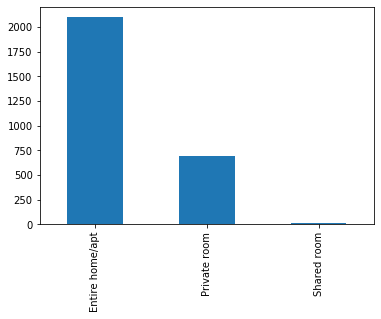

In [10]:
df[df['neighbourhood'] == 'Port Phillip']['room_type'].value_counts().plot(kind='bar')